## GRU - With RDA data representation approach *Geo-coordinate estimation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import math

import tensorflow as tf
from tensorflow.keras.models import load_model


In [2]:
to_store_path = r'D:\2 Thesis\2 models\2023.07.02 all models\GRU_02\prediction csv\rrangle_rdist_gru_output_v1_7474.csv'

In [3]:
X_test_path = r'D:\2 Thesis\1 train datasets\2 train rda\3 test\data_2019_12_X.npy'
X_test = np.load(X_test_path)

In [4]:
rangle_path = r'D:\2 Thesis\2 models\2023.07.02 all models\GRU_02\prediction csv\v1_gru_pred_output_rr_angle.csv'
rdist_path = r'D:\2 Thesis\2 models\2023.07.02 all models\GRU_02\prediction csv\v1_gru_pred_output_rel_dist.csv'
Y_test_lat_path = r'D:\2 Thesis\1 train datasets\2 train rda\3 test\data_2019_12_Y_lat.npy'
Y_test_lon_path = r'D:\2 Thesis\1 train datasets\2 train rda\3 test\data_2019_12_Y_lon.npy'

In [7]:
rangle_test_df = pd.read_csv(rangle_path)
rdist_test_df = pd.read_csv(rdist_path)

In [8]:
rangle_test_df = rangle_test_df.drop('Unnamed: 0', axis=1)
rdist_test_df = rdist_test_df.drop('Unnamed: 0', axis=1)

In [9]:
rangle_test_df['rangle_pred'] = rangle_test_df.apply(lambda row: math.degrees(math.atan2(row['sin_rangle_pred'], row['cos_rangle_pred'])), axis=1)
rangle_test_df['rangle'] = rangle_test_df.apply(lambda row: math.degrees(math.atan2(row['sin_rangle'], row['cos_rangle'])), axis=1)

In [12]:
Y_test_df = pd.concat([rangle_test_df, rdist_test_df], axis=1)

In [13]:

X_test_flat = X_test.flatten()
# print(X_test_flat)

# reshape to 2D array with 5 columns
X_test_array = X_test_flat.reshape(-1, 8)

# convert to pandas dataframe
X_test_df = pd.DataFrame(X_test_array, columns=['lat_s', 'lon_s', 'sog_s', 'cog_sin', 'cog_cos', 'ndc_s', 'in_tss', 'TSS_Vessel'])

In [15]:
# converting back to lat long degrees

min_lat, max_lat = 58.6, 59.93
min_lon, max_lon = 9.4, 11.45

# Y_pred_df['lat_pred'] = Y_pred_df['lat_s_pred'] * (max_lat - min_lat) + min_lat
# Y_pred_df['lon_pred'] = Y_pred_df['lon_s_pred'] * (max_lon - min_lon) + min_lon

# Y_test_df['lat_test'] = Y_test_df['lat_s_test'] * (max_lat - min_lat) + min_lat
# Y_test_df['lon_test'] = Y_test_df['lon_s_test'] * (max_lon - min_lon) + min_lon

X_test_df['lat'] = X_test_df['lat_s'] * (max_lat - min_lat) + min_lat
X_test_df['lon'] = X_test_df['lon_s'] * (max_lon - min_lon) + min_lon
X_test_df['voyage_id'] = X_test_df.index // 10
X_test_df['step'] = np.arange(len(X_test_df)) % 10


In [16]:
X_test_df['cog'] = np.degrees(np.arctan2(X_test_df['cog_sin'], X_test_df['cog_cos']))

In [18]:
Y_test_df['lat_ref'] = 0
Y_test_df['lon_ref'] = 0
Y_test_df['cog_ref'] = 0

start_indices = np.arange(0, len(Y_test_df), 10)
end_indices = start_indices + 9

lat_val = X_test_df['lat'].values[end_indices]
lon_val = X_test_df['lon'].values[end_indices]
cog_val = X_test_df['cog'].values[end_indices]


lat_rep = np.repeat(lat_val, 10)
lon_rep = np.repeat(lon_val, 10)
cog_rep = np.repeat(cog_val, 10)

Y_test_df['lat_ref'] = lat_rep[:len(Y_test_df)]
Y_test_df['lon_ref'] = lon_rep[:len(Y_test_df)]
Y_test_df['cog_ref'] = cog_rep[:len(Y_test_df)]

In [20]:
(abs((Y_test_df['rel_dist_pred']) - Y_test_df['rel_dist'])).mean()

48.76467629978804

In [21]:
(abs(Y_test_df['rangle_pred'] - Y_test_df['rangle'])).mean()

7.337733287222108

In [23]:
Y_test_df['angle_pred'] = Y_test_df['cog_ref'] - Y_test_df['rangle_pred']

In [25]:
Y_test_df['lat2'] = 0
Y_test_df['lon2'] = 0


In [27]:
import numpy as np
import pandas as pd

def reverse_haversine(df):
    R = 6378.137  # Radius of Earth in km
    
    lat1 = np.radians(df['lat_ref'].values)
    lon1 = np.radians(df['lon_ref'].values)
    bearing = np.radians(df['angle_pred'].values)
    distance = df['rel_dist_pred'].values/1000
    
    angdist = distance / R
    
    lat2 = np.degrees(np.arcsin((np.sin(lat1) * np.cos(angdist)) + (np.cos(lat1) * np.sin(angdist) * np.cos(bearing))))
    lon2 = np.degrees(lon1 + np.arctan2((np.sin(bearing) * np.sin(angdist) * np.cos(lat1)), (np.cos(angdist) - (np.sin(lat1) * np.sin(np.radians(lat2))))))
    
    df['lat2'] = lat2
    df['lon2'] = lon2
    
    return df

Y_test_df= reverse_haversine(Y_test_df)

In [29]:
Y_test_df.head()

,sin_rangle_pred,cos_rangle_pred,sin_rangle,cos_rangle,rangle_pred,rangle,rel_dist_s,rel_dist_pred_s,rel_dist_pred,rel_dist,lat_ref,lon_ref,cog_ref,angle_pred,lat2,lon2
0,0.009064,1.005016,-0.002712,0.999996,0.516726,-0.155399,0.027302,0.026928,161.56725,163.813228,59.098676,9.633556,-160.007106,-160.523832,59.097307,9.632613
1,0.034638,0.980720,0.016047,0.999871,2.022757,0.919452,0.053524,0.052483,314.90033,321.142259,59.098676,9.633556,-160.007106,-162.029863,59.095985,9.631856
2,0.053852,1.013532,0.034747,0.999396,3.041447,1.991254,0.078404,0.076393,458.35703,470.425221,59.098676,9.633556,-160.007106,-163.048553,59.094737,9.631218
3,0.032115,0.941262,0.081833,0.996646,1.954100,4.693913,0.103705,0.098673,592.04080,622.228555,59.098676,9.633556,-160.007106,-161.961206,59.093619,9.630349
4,0.040153,0.877550,0.143855,0.989599,2.619755,8.271003,0.127769,0.119986,719.91833,766.612898,59.098676,9.633556,-160.007106,-162.626861,59.092503,9.629796


In [31]:
# Y_test_df.to_csv(to_store_interim_path)

In [32]:
Y_test_lat = np.load(Y_test_lat_path)
Y_test_lon = np.load(Y_test_lon_path)

In [33]:
Y_test_lat_flat = Y_test_lat.flatten()
Y_test_lat_df = pd.DataFrame(Y_test_lat_flat, columns=['lat_s_test'])

Y_test_lon_flat = Y_test_lon.flatten()
Y_test_lon_df = pd.DataFrame(Y_test_lon_flat, columns=['lon_s_test'])

# Concatnating the lat lon test data - to on df
Y_test_and_pred_df = pd.concat([Y_test_lat_df, Y_test_lon_df, Y_test_df], axis=1)

In [34]:
# converting back to lat long degrees

min_lat, max_lat = 58.6, 59.93
min_lon, max_lon = 9.4, 11.45

Y_test_and_pred_df['lat_test'] = Y_test_and_pred_df['lat_s_test'] * (max_lat - min_lat) + min_lat
Y_test_and_pred_df['lon_test'] = Y_test_and_pred_df['lon_s_test'] * (max_lon - min_lon) + min_lon


In [35]:
Y_test_and_pred_df

,lat_s_test,lon_s_test,sin_rangle_pred,cos_rangle_pred,sin_rangle,cos_rangle,rangle_pred,rangle,rel_dist_s,rel_dist_pred_s,rel_dist_pred,rel_dist,lat_ref,lon_ref,cog_ref,angle_pred,lat2,lon2,lat_test,lon_test
0,0.373904,0.113448,0.009064,1.005016,-0.002712,0.999996,0.516726,-0.155399,0.027302,0.026928,161.56725,163.813228,59.098676,9.633556,-160.007106,-160.523832,59.097307,9.632613,59.097293,9.632568
1,0.372892,0.113033,0.034638,0.980720,0.016047,0.999871,2.022757,0.919452,0.053524,0.052483,314.90033,321.142259,59.098676,9.633556,-160.007106,-162.029863,59.095985,9.631856,59.095946,9.631718
2,0.371919,0.112688,0.053852,1.013532,0.034747,0.999396,3.041447,1.991254,0.078404,0.076393,458.35703,470.425221,59.098676,9.633556,-160.007106,-163.048553,59.094737,9.631218,59.094652,9.631010
3,0.370886,0.112527,0.032115,0.941262,0.081833,0.996646,1.954100,4.693913,0.103705,0.098673,592.04080,622.228555,59.098676,9.633556,-160.007106,-161.961206,59.093619,9.630349,59.093278,9.630681
4,0.369868,0.112599,0.040153,0.877550,0.143855,0.989599,2.619755,8.271003,0.127769,0.119986,719.91833,766.612898,59.098676,9.633556,-160.007106,-162.626861,59.092503,9.629796,59.091925,9.630829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9062885,0.006122,0.135395,0.001800,0.985965,0.043834,0.999039,0.104614,2.512306,0.157002,0.161242,967.45120,942.011137,58.616380,9.681360,-163.975890,-164.080504,58.608022,9.676784,58.608143,9.677560
9062886,0.005035,0.135063,0.002101,0.985491,0.043084,0.999071,0.122167,2.469293,0.184597,0.190656,1143.93820,1107.580769,58.616380,9.681360,-163.975890,-164.098057,58.606497,9.675955,58.606697,9.676878
9062887,0.004023,0.134756,0.000943,0.985471,0.042849,0.999082,0.054813,2.455822,0.210280,0.218813,1312.87890,1261.682771,58.616380,9.681360,-163.975890,-164.030704,58.605041,9.675131,58.605350,9.676250
9062888,0.002939,0.134447,0.001534,0.984685,0.044213,0.999022,0.089284,2.534049,0.237672,0.245285,1471.71240,1426.033190,58.616380,9.681360,-163.975890,-164.065174,58.603667,9.674393,58.603909,9.675617


In [36]:
from haversine import haversine, Unit

Y_test_and_pred_df['deviation_dist_m'] = Y_test_and_pred_df.apply(lambda row: haversine(
    (row['lat2'], 
    row['lon2']),
    (row['lat_test'], 
    row['lon_test']),
    unit=Unit.METERS
    ),axis=1)

In [37]:
mean_deviation = Y_test_and_pred_df['deviation_dist_m'].mean()
median_deviation = Y_test_and_pred_df['deviation_dist_m'].median()

print('GRU_model mean_displacement_error:', mean_deviation)
print('GRU_model median_displacement_error:', median_deviation)

GRU_model mean_displacement_error: 103.00543468973748
GRU_model median_displacement_error: 40.733972356815215


In [38]:
step_means = []
for step in range(10):
    step_mean = Y_test_and_pred_df['deviation_dist_m'][step::9].mean()
    step_means.append(step_mean)


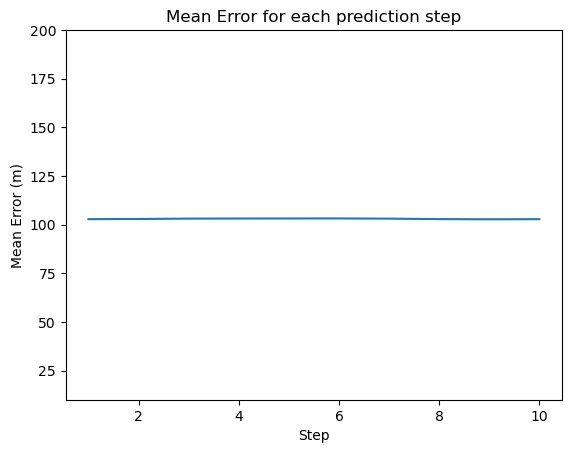

In [39]:
import matplotlib.pyplot as plt

plt.plot(range(1, 11), step_means)
plt.xlabel('Step')
plt.ylabel('Mean Error (m)')
plt.title('Mean Error for each prediction step')
plt.ylim(10, 200)
plt.show()


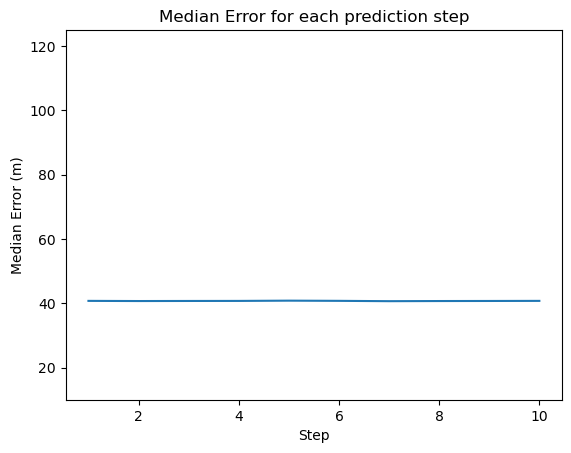

In [40]:
import matplotlib.pyplot as plt

step_medians = []
for step in range(10):
    step_median = Y_test_and_pred_df['deviation_dist_m'][step::9].median()
    step_medians.append(step_median)

plt.plot(range(1, 11), step_medians)
plt.xlabel('Step')
plt.ylabel('Median Error (m)')
plt.title('Median Error for each prediction step')
plt.ylim(10,125)
plt.show()


In [41]:

step_FDE = Y_test_and_pred_df['deviation_dist_m'][9::9].mean()
print('Final displacement error (meters) is:', step_FDE)

Final displacement error (meters) is: 102.82016316654723


In [42]:
Y_test_and_pred_df['voyage_id'] = Y_test_and_pred_df.index // 10
Y_test_and_pred_df['step'] = np.arange(len(Y_test_and_pred_df)) % 10


In [43]:
Y_test_and_pred_df.to_csv(to_store_path)
